Air quality data of European monitoring stations (AirBase)

**AirBase (The European Air quality dataBase): hourly measurements of all air quality monitoring stations from Europe.**


---

AirBase is the European air quality database maintained by the European Environment Agency (EEA). It contains air quality monitoring data and information submitted by participating countries throughout Europe. The air quality database consists of a multi-annual time series of air quality measurement data and statistics for a number of air pollutants.

Some of the data files that are available from AirBase were included in the data folder: the hourly **concentrations of nitrogen dioxide (NO2)** for 4 different measurement stations:

- FR04037 (PARIS 13eme): urban background site at Square de Choisy
- FR04012 (Paris, Place Victor Basch): urban traffic site at Rue d'Alesia
- BETR802: urban traffic site in Antwerp, Belgium
- BETN029: rural background site in Houtem, Belgium

See http://www.eea.europa.eu/themes/air/interactive/no2

In [160]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 8

# Processing a single file

We will start with processing one of the downloaded files (`BETR8010000800100hour.1-1-1990.31-12-2012`). Looking at the data, you will see it does not look like a nice csv file:

In [161]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [162]:
import os
os.chdir('/content/gdrive/My Drive/Teaching-task/introduction-to-ai/lab-practice')
!pwd

/content/gdrive/My Drive/Teaching-task/introduction-to-ai/lab-practice


In [163]:
with open("BETR8010000800100hour.1-1-1990.31-12-2012") as f:
    print(f.readline())

1990-01-01	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0	-999.000	0



So we will need to do some manual processing.

Just reading the tab-delimited data:

In [164]:
data = pd.read_csv("BETR8010000800100hour.1-1-1990.31-12-2012", sep='\t')#, header=None)

In [165]:
data.head()

,1990-01-01,-999.000,0,-999.000.1,0.1,-999.000.2,0.2,-999.000.3,0.3,-999.000.4,0.4,-999.000.5,0.5,-999.000.6,0.6,-999.000.7,0.7,-999.000.8,0.8,-999.000.9,0.9,-999.000.10,0.10,-999.000.11,0.11,-999.000.12,0.12,-999.000.13,0.13,-999.000.14,0.14,-999.000.15,0.15,-999.000.16,0.16,-999.000.17,0.17,-999.000.18,0.18,-999.000.19,0.19,-999.000.20,0.20,-999.000.21,0.21,-999.000.22,0.22,-999.000.23,0.23
0,1990-01-02,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,48.0,1,-999.0,0,-999.0,0,48.0,1,50.0,1,55.0,1,59.0,1,58.0,1,59.0,1,58.0,1,57.0,1,58.0,1,54.0,1,49.0,1,48.0,1
1,1990-01-03,51.0,1,50.0,1,47.0,1,48.0,1,51.0,1,52.0,1,58.0,1,57.0,1,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,69.0,1,74.0,1,-999.0,0,-999.0,0,103.0,1,84.0,1,75.0,1,-999.0,0,-999.0,0,-999.0,0
2,1990-01-04,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,67.0,1,57.0,1,57.0,1,-999.0,0,71.0,1,74.0,1,70.0,1,70.0,1,69.0,1,65.0,1,64.0,1,60.0,1,59.0,1
3,1990-01-05,51.0,1,51.0,1,48.0,1,50.0,1,51.0,1,58.0,1,65.0,1,66.0,1,69.0,1,74.0,1,80.0,1,83.0,1,84.0,1,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0
4,1990-01-06,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0,-999.0,0


The above data is clearly not ready to be used! Each row contains the 24 measurements for each hour of the day, and also contains a flag (0/1) indicating the quality of the data. Furthermore, there is no header row with column names.

<div class="alert alert-success">

<b>EXERCISE</b>: <br><br> Clean up this dataframe by using more options of `read_csv` (see its [docstring](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html))

 <ul>
  <li>specify the correct delimiter</li>
  <li>specify that the values of -999 and -9999 should be regarded as NaN</li>
  <li>specify are own column names (for how the column names are made up, see See http://stackoverflow.com/questions/6356041/python-intertwining-two-lists)
</ul>
</div>

In [166]:
# Column names: list consisting of 'date' and then intertwined the hour of the day and 'flag'
hours = ["{:02d}".format(i) for i in range(24)]
column_names = ['date'] + [item for pair in zip(hours, ['flag']*24) for item in pair]

In [167]:
# Answer
data = pd.read_csv("BETR8010000800100hour.1-1-1990.31-12-2012",
                  sep = '\t', header = None, na_values = [-999,-9999])
data.columns = column_names

In [168]:
data.head()

,date,00,flag,01,flag,02,flag,03,flag,04,flag,05,flag,06,flag,07,flag,08,flag,09,flag,10,flag,11,flag,12,flag,13,flag,14,flag,15,flag,16,flag,17,flag,18,flag,19,flag,20,flag,21,flag,22,flag,23,flag
0,1990-01-01,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
1,1990-01-02,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,48.0,1,NaN,0,NaN,0,48.0,1,50.0,1,55.0,1,59.0,1,58.0,1,59.0,1,58.0,1,57.0,1,58.0,1,54.0,1,49.0,1,48.0,1
2,1990-01-03,51.0,1,50.0,1,47.0,1,48.0,1,51.0,1,52.0,1,58.0,1,57.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,69.0,1,74.0,1,NaN,0,NaN,0,103.0,1,84.0,1,75.0,1,NaN,0,NaN,0,NaN,0
3,1990-01-04,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,67.0,1,57.0,1,57.0,1,NaN,0,71.0,1,74.0,1,70.0,1,70.0,1,69.0,1,65.0,1,64.0,1,60.0,1,59.0,1
4,1990-01-05,51.0,1,51.0,1,48.0,1,50.0,1,51.0,1,58.0,1,65.0,1,66.0,1,69.0,1,74.0,1,80.0,1,83.0,1,84.0,1,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0


<div class="alert alert-success">

<b>EXERCISE</b>:
<br><br>
Drop all 'flag' columns ('flag1', 'flag2', ...) 

In [169]:
# Answer
flag_columns = [col for col in data.columns if 'flag' in col]

In [170]:
# # we can now use this list to drop these columns
data = data.drop(flag_columns, axis = 1)

In [171]:
data.head()

,date,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1990-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,48.0,50.0,55.0,59.0,58.0,59.0,58.0,57.0,58.0,54.0,49.0,48.0
2,1990-01-03,51.0,50.0,47.0,48.0,51.0,52.0,58.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,69.0,74.0,NaN,NaN,103.0,84.0,75.0,NaN,NaN,NaN
3,1990-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,57.0,57.0,NaN,71.0,74.0,70.0,70.0,69.0,65.0,64.0,60.0,59.0
4,1990-01-05,51.0,51.0,48.0,50.0,51.0,58.0,65.0,66.0,69.0,74.0,80.0,83.0,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now, we want to reshape it: our goal is to have the different hours as row indices, merged with the date into a datetime-index. Here we have a wide and long dataframe, and want to make this a long, narrow timeseries.

<div class="alert alert-success">

<b>EXERCISE</b>:

<br><br>

Reshape the dataframe to a timeseries. 
The end result should look like:<br><br>


<div class='center'>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>BETR801</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1990-01-02 09:00:00</th>
      <td>48.0</td>
    </tr>
    <tr>
      <th>1990-01-02 12:00:00</th>
      <td>48.0</td>
    </tr>
    <tr>
      <th>1990-01-02 13:00:00</th>
      <td>50.0</td>
    </tr>
    <tr>
      <th>1990-01-02 14:00:00</th>
      <td>55.0</td>
    </tr>
    <tr>
      <th>...</th>
      <td>...</td>
    </tr>
    <tr>
      <th>2012-12-31 20:00:00</th>
      <td>16.5</td>
    </tr>
    <tr>
      <th>2012-12-31 21:00:00</th>
      <td>14.5</td>
    </tr>
    <tr>
      <th>2012-12-31 22:00:00</th>
      <td>16.5</td>
    </tr>
    <tr>
      <th>2012-12-31 23:00:00</th>
      <td>15.0</td>
    </tr>
  </tbody>
</table>
<p style="text-align:center">170794 rows × 1 columns</p>
</div>

 <ul>
  <li>Reshape the dataframe so that each row consists of one observation for one date + hour combination</li>
  <li>When you have the date and hour values as two columns, combine these columns into a datetime (tip: string columns can be summed to concatenate the strings) and remove the original columns</li>
  <li>Set the new datetime values as the index, and remove the original columns with date and hour values</li>

</ul>


**NOTE**: This is an advanced exercise. Do not spend too much time on it and don't hesitate to look at the solutions. 

</div>



In [172]:
# we use stack to reshape the data to move the hours (the column labels) into a column.
# But we don't want to move the 'date' column label, therefore we first set this as the index.
# You can check the difference with "data.stack()"
data2 = data.set_index('date')
data_stacked = data2.stack()
data_stacked.head()

date          
1990-01-02  09    48.0
            12    48.0
            13    50.0
            14    55.0
            15    59.0
dtype: float64

In [173]:
# We reset the index to have the date and hours available as columns
data_stacked = data_stacked.reset_index()
data_stacked.head()

,date,level_1,0
0,1990-01-02,09,48.0
1,1990-01-02,12,48.0
2,1990-01-02,13,50.0
3,1990-01-02,14,55.0
4,1990-01-02,15,59.0


In [174]:
# Now we combine the dates and the hours into a datetime, and set this as the index
data_stacked.index = pd.to_datetime(data_stacked['date'] + data_stacked['level_1'], format="%Y-%m-%d%H")

In [175]:
# Drop the origal date and hour columns
data_stacked = data_stacked.drop(['date', 'level_1'], axis=1)
data_stacked.head()

,0
1990-01-02 09:00:00,48.0
1990-01-02 12:00:00,48.0
1990-01-02 13:00:00,50.0
1990-01-02 14:00:00,55.0
1990-01-02 15:00:00,59.0


In [176]:
# rename the remaining column to the name of the measurement station
data_stacked = data_stacked.rename(columns={0: 'BETR801'})

In [177]:
data_stacked.head()

,BETR801
1990-01-02 09:00:00,48.0
1990-01-02 12:00:00,48.0
1990-01-02 13:00:00,50.0
1990-01-02 14:00:00,55.0
1990-01-02 15:00:00,59.0


Our final data is now a time series. In pandas, this means that the index is a `DatetimeIndex`:

In [178]:
data_stacked.index

DatetimeIndex(['1990-01-02 09:00:00', '1990-01-02 12:00:00',
               '1990-01-02 13:00:00', '1990-01-02 14:00:00',
               '1990-01-02 15:00:00', '1990-01-02 16:00:00',
               '1990-01-02 17:00:00', '1990-01-02 18:00:00',
               '1990-01-02 19:00:00', '1990-01-02 20:00:00',
               ...
               '2012-12-31 12:00:00', '2012-12-31 13:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', length=170794, freq=None)

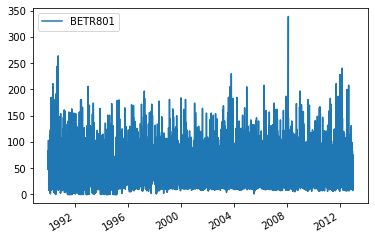

In [179]:
data_stacked.plot()

# Processing a collection of files

We now have seen the code steps to process one of the files. We have however multiple files for the different stations with the same structure. Therefore, to not have to repeat the actual code, let's make a function from the steps we have seen above.

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Write a function `read_airbase_file(filename, station)`, using the above steps the read in and process the data, and that returns a processed timeseries.</li>
</ul>
</div>

In [180]:
def read_airbase_file(filename, station):
    """
    Read hourly AirBase data files.
    
    Parameters
    ----------
    filename : string
        Path to the data file.
    station : string
        Name of the station.
       
    Returns
    -------
    DataFrame
        Processed dataframe.
    """
    # Column names: list consisting of 'date' and then intertwined the hour of the day and 'flag'
    hours = ["{:02d}".format(i) for i in range(24)]
    colnames = ['date'] + [item for pair in zip(hours, ['flag']*24) for item in pair]
    
    # read the actual data
    data = pd.read_csv("BETR8010000800100hour.1-1-1990.31-12-2012", sep = '\t', header = None, na_values = [-999,-9999])
    data.columns = colnames
    
    #drop the 'flag' columns
    data = data.drop([col for col in data.columns if 'flag' in col], axis = 1)
    
    #reshape
    data2 = data.set_index('date')
    data_stacked = data2.stack()
    data_stacked = data_stacked.reset_index()
    
    #parse to datetime and remove redundant columns
    data_stacked.index = pd.to_datetime(data_stacked['date'] + data_stacked['level_1'], format="%Y-%m-%d%H")
    data_stacked = data_stacked.drop(['date', 'level_1'], axis=1)
    data_stacked = data_stacked.rename(columns={0: station})

    return data_stacked

Test the function on the data file from above:

In [181]:
filename = "BETR8010000800100hour.1-1-1990.31-12-2012"
station = filename.split("/")[-1][:7]

In [182]:
station

'BETR801'

In [183]:
test = read_airbase_file(filename, station)
test.head()

,BETR801
1990-01-02 09:00:00,48.0
1990-01-02 12:00:00,48.0
1990-01-02 13:00:00,50.0
1990-01-02 14:00:00,55.0
1990-01-02 15:00:00,59.0


We now want to use this function to read in all the different data files from AirBase, and combine them into one Dataframe. 

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Use the `glob.glob` function to list all 4 AirBase data files that are included in the 'data' directory, and call the result `data_files`.</li>
</ul>
</div>

In [184]:
import glob

In [185]:
# Answer
data_files = glob.glob("*0008001*")
data_files

['FR040370000800100hour.1-1-1999.31-12-2012',
 'BETN0290000800100hour.1-1-1990.31-12-2012',
 'BETR8010000800100hour.1-1-1990.31-12-2012']

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Loop over the data files, read and process the file using our defined function, and append the dataframe to a list.</li>
  <li>Combine the the different DataFrames in the list into a single DataFrame where the different columns are the different stations. Call the result `combined_data`.</li>

</ul>
</div>

In [186]:
# %load snippets/07 - Case study - air quality data34.py
dfs = []

for filename in data_files:
    station = filename.split("/")[-1][:7]
    df = read_airbase_file(filename, station)
    dfs.append(df)

In [187]:
# %load snippets/07 - Case study - air quality data35.py
combined_data = pd.concat(dfs, axis=1)

In [188]:
combined_data.head()

,FR04037,BETN029,BETR801
1990-01-02 09:00:00,48.0,48.0,48.0
1990-01-02 12:00:00,48.0,48.0,48.0
1990-01-02 13:00:00,50.0,50.0,50.0
1990-01-02 14:00:00,55.0,55.0,55.0
1990-01-02 15:00:00,59.0,59.0,59.0


Finally, we don't want to have to repeat this each time we use the data. Therefore, let's save the processed data to a csv file.

In [189]:
# Answer
combined_data.to_csv('combine_data.csv')

# Working with time series data

We processed the individual data files above, and saved it to a csv file `airbase_data.csv`. Let's import the file here (if you didn't finish the above exercises, a version of the dataset is also available in `data/airbase_data.csv`):

In [190]:
alldata = pd.read_csv('airbase_data.csv', index_col=0, parse_dates=True)

We copy another dataframe and only use the data from 1999 onwards:

In [191]:
# Answer
data = alldata['1999':].copy()

In [192]:
data.head()

,BETR801
1999-01-01 00:00:00,27.0
1999-01-01 01:00:00,33.0
1999-01-01 02:00:00,24.0
1999-01-01 03:00:00,26.0
1999-01-01 06:00:00,34.0


Som first exploration with the *typical* functions:

In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106628 entries, 1999-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BETR801  106628 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [194]:
data.describe(percentiles=[0.1, 0.5, 0.9])

,BETR801
count,106628.000000
mean,46.728969
std,21.708333
min,1.000000
10%,21.000000
50%,45.000000
90%,75.000000
max,339.000000


Quickly visualizing the data

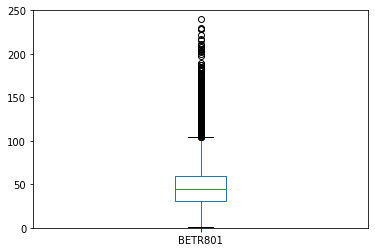

In [195]:
data.plot(kind='box', ylim=[0,250])

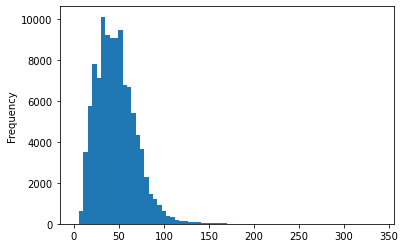

In [196]:
data['BETR801'].plot(kind='hist', bins=70)

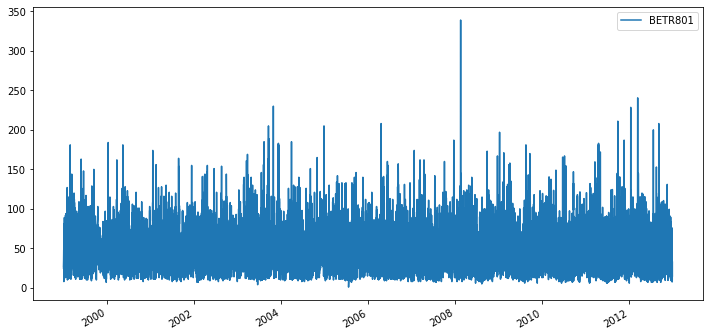

In [197]:
data.plot(figsize=(12,6))

This does not say too much ..

We can select part of the data (eg the latest 500 data points):

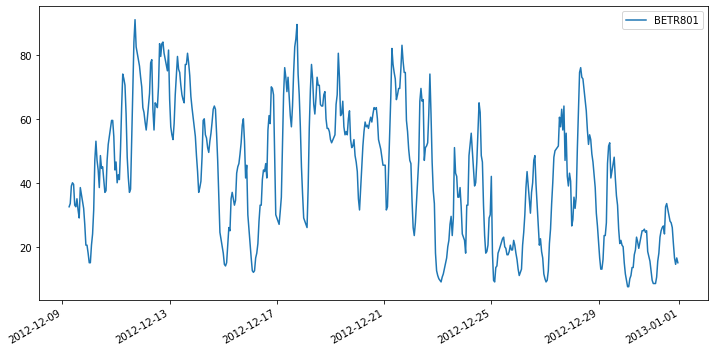

In [198]:
data[-500:].plot(figsize=(12,6))

## Exercises

<div class="alert alert-warning">

<b>REMINDER</b>: <br><br>

Take a look at the [Timeseries notebook] about...

 <ul>
  <li>`resample`</li>
  <li>string indexing of DateTimeIndex</li>
</ul><br><br>

</div>

<div class="alert alert-success">
    <b>QUESTION</b>: plot the monthly mean and median concentration of the 'FR04037' station for the years 2009-2012
</div>

In [199]:
data_files = glob.glob("*0370000*")
data_files

['FR040370000800100hour.1-1-1999.31-12-2012']

In [200]:
dfs = []

for filename in data_files:
    station = filename.split("/")[-1][:7]
    df = read_airbase_file(filename, station)
    dfs.append(df)

In [201]:
combined_data = pd.concat(dfs, axis=1)
combined_data.head()

,FR04037
1990-01-02 09:00:00,48.0
1990-01-02 12:00:00,48.0
1990-01-02 13:00:00,50.0
1990-01-02 14:00:00,55.0
1990-01-02 15:00:00,59.0


In [202]:
data = combined_data.copy()
data.head()

,FR04037
1990-01-02 09:00:00,48.0
1990-01-02 12:00:00,48.0
1990-01-02 13:00:00,50.0
1990-01-02 14:00:00,55.0
1990-01-02 15:00:00,59.0


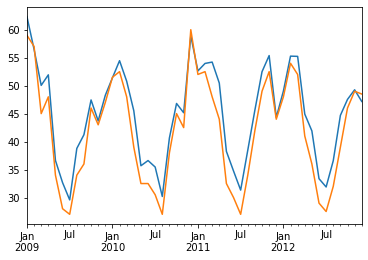

In [203]:
# plot the monthly mean and median concentration of the 'FR04037' station for the years 2009-2012
data.loc['2009':, 'FR04037'].resample('M').mean().plot()
data.loc['2009':, 'FR04037'].resample('M').median().plot()

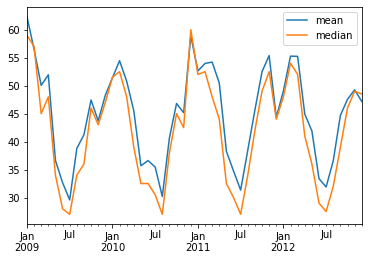

In [204]:
# Answer in one line of code
data.loc['2009':, 'FR04037'].resample('M').agg(['mean', 'median']).plot()

<div class="alert alert-success">
    <b>QUESTION</b>: plot the monthly mininum and maximum daily concentration of the 'FR04037' station
</div>

In [205]:
# Generate the resampled data by daily
daily = data['FR04037'].resample('D').mean()

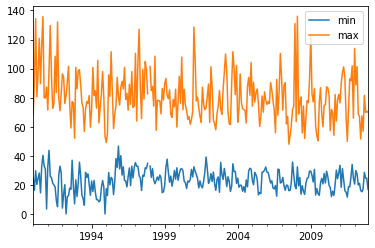

In [206]:
# plot the monthly mininum and maximum daily concentration of the 'FR04037' station
daily.resample('M').agg(['min', 'max']).plot()

<div class="alert alert-success">
    <b>QUESTION</b>: make a bar plot of the mean of the stations in year of 2012
</div>

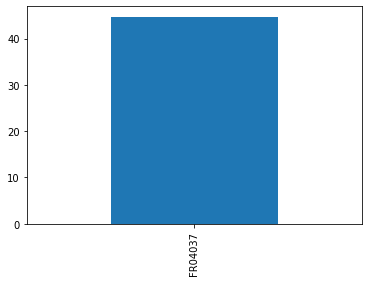

In [207]:
# make a bar plot of the mean of the stations in year of 2012
data['2012'].mean().plot(kind='bar')

<div class="alert alert-success">
    <b>QUESTION</b>: The evolution of the yearly averages with, and the overall mean of all stations (indicate the overall mean with a thicker black line)?
</div>

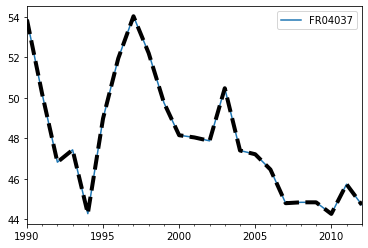

In [208]:
# Answer
data.resample('A').mean().plot()
data.mean(axis = 1).resample('A').mean().plot(color = 'k', linestyle = '--', linewidth = 4)

### Combination with groupby

`resample` can actually be seen as a specific kind of `groupby`. E.g. taking annual means with `data.resample('A', 'mean')` is equivalent to `data.groupby(data.index.year).mean()` (only the result of `resample` still has a DatetimeIndex).



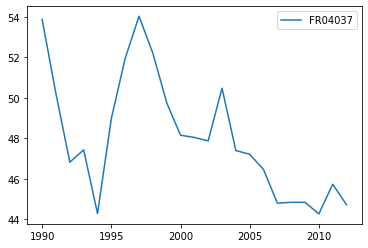

In [209]:
data.groupby(data.index.year).mean().plot()

But, `groupby` is more flexible and can also do resamples that do not result in a new continuous time series, e.g. by grouping by the hour of the day to get the diurnal cycle.

<div class="alert alert-success">
    <b>QUESTION</b>: how does the *typical monthly profile* look like for the different stations?
</div>

1\. add a column to the dataframe that indicates the month (integer value of 1 to 12):

In [210]:
# Answer 
data['month']= data.index.month

2\. Now, we can calculate the mean of each month over the different years:

In [211]:
# Answer
data.groupby('month').mean()

,FR04037
month,
1,50.927088
2,54.168021
3,54.598322
4,51.491741
...,...
9,49.220250
10,50.894911
11,50.254468
12,48.644117


3\. plot the typical monthly profile of the different stations:

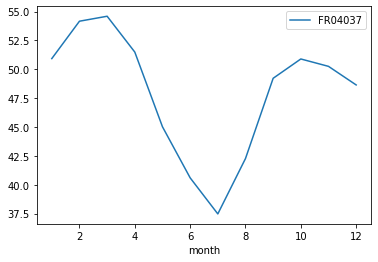

In [212]:
# Answer
data.groupby('month').mean().plot()

In [213]:
data = data.drop('month', axis=1, errors='ignore')

<div class="alert alert-success">
    <b>QUESTION</b>: plot the weekly 95% percentiles of the concentration in 'FR04037' for 2011
</div>

In [214]:
df2011 = data['2011'].dropna()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


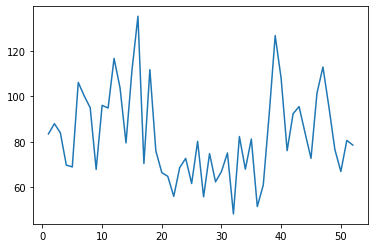

In [215]:
# plot the weekly 95% percentiles of the concentration in 'FR04037' for 2011
df2011 = data['2011'].dropna()
df2011.groupby(df2011.index.week)['FR04037'].quantile(0.95).plot()

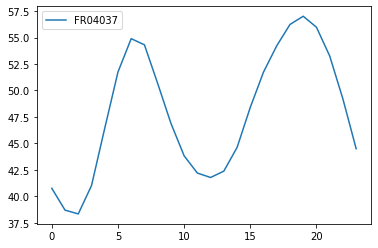

In [216]:
# %load snippets/07 - Case study - air quality data66.py
data.groupby(data.index.hour).mean().plot()

<div class="alert alert-success">
    <b>QUESTION</b>: What are the number of exceedances of hourly values above the station limit 200 µg/m3 for each year/station?
</div>

In [217]:
# Answer
exceedances = data > 200

In [218]:
# %load snippets/07 - Case study - air quality data68.py
# group by year and count exceedances (sum of boolean)
exceedances = exceedances.groupby(exceedances.index.year).sum()

In [219]:
# Print out
exceedances

,FR04037
1990,10
1991,0
1992,1
1993,0
...,...
2009,0
2010,0
2011,1
2012,6


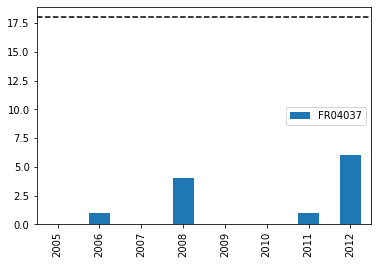

In [220]:
# plot exceedances
ax = exceedances.loc[2005:].plot(kind='bar')
ax.axhline(18, color='k', linestyle='--')

<div class="alert alert-success">
    <b>QUESTION</b>: And are there exceedances of the yearly limit value of 40 µg/m3 since 200 ?
</div>

In [221]:
yearly = data['2000':].resample('A').mean()

In [222]:
(yearly > 40).sum()

FR04037    13
dtype: int64

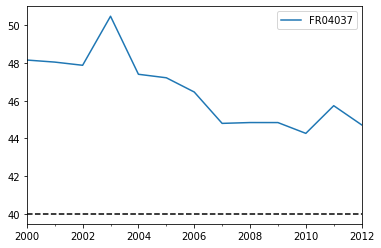

In [223]:
# plot yearly
yearly.plot()
plt.axhline(40, linestyle='--', color='k')

<div class="alert alert-success">
    <b>QUESTION</b>: What is the difference in the typical diurnal profile between week and weekend days? (and visualise it)
</div>

In [224]:
data.index.weekday?

In [225]:
data['weekday'] = data.index.weekday

Add a column indicating week/weekend

In [226]:
# Answer
data['weekend'] = data['weekday'].isin([5,6])

In [227]:
# Answer
data_weekend = data.groupby(['weekend', data.index.hour]).mean()
data_weekend.head()

FR04037   weekday
weekend                       
False   0  40.008066  2.009869
        1  38.281875  2.008576
        2  38.601189  2.007098
        3  42.633946  2.007737
        4  49.853566  2.012471

In [228]:
# using unstack
data_weekend_FR04037 = data_weekend['FR04037'].unstack(level=0)
data_weekend_FR04037.head()

weekend,False,True
0,40.008066,42.606821
1,38.281875,39.698565
2,38.601189,37.649595
3,42.633946,36.971797
4,49.853566,37.908454


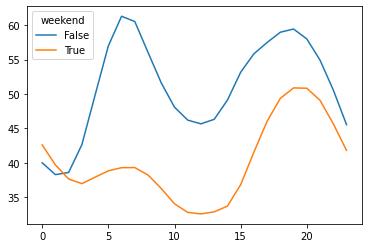

In [229]:
# Plot result 
data_weekend_FR04037.plot()

In [230]:
# %load snippets/07 - Case study - air quality data81.py
data = data.drop(['weekday', 'weekend'], axis=1)

<div class="alert alert-success">
    <b>QUESTION</b>: Visualize the typical week profile for the different stations as boxplots (where the values in one boxplot are the daily means for the different weeks for a certain weekday).
</div>

Tip: the boxplot method of a DataFrame expects the data for the different boxes in different columns). For this, you can either use `pivot_table` as a combination of `groupby` and `unstack`

In [231]:
# %load snippets/07 - Case study - air quality data82.py
# add a weekday and week column
data['weekday'] = data.index.weekday
data['week'] = data.index.week
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


,FR04037,weekday,week
1990-01-02 09:00:00,48.0,1,1
1990-01-02 12:00:00,48.0,1,1
1990-01-02 13:00:00,50.0,1,1
1990-01-02 14:00:00,55.0,1,1
1990-01-02 15:00:00,59.0,1,1


In [232]:
# pivot table so that the weekdays are the different columns
data_pivoted = data['2012'].pivot_table(columns = 'weekday', index='week', values='FR04037')
data_pivoted.head()

weekday,0,1,2,3,4,5,6
week,,,,,,,
1,28.545455,25.727273,30.260870,22.704545,44.473684,27.113636,39.590909
2,55.227273,60.113636,50.250000,42.550000,58.704545,68.181818,68.568182
3,73.704545,113.863636,61.045455,43.636364,43.363636,28.826087,22.340909
4,46.944444,71.659091,57.565217,59.833333,65.818182,50.181818,29.500000
5,47.775000,53.750000,41.318182,44.227273,72.250000,76.409091,68.500000


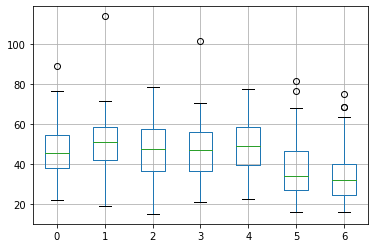

In [233]:
# plot box-plot
box = data_pivoted.boxplot()

An alternative method using `groupby` and `unstack`:

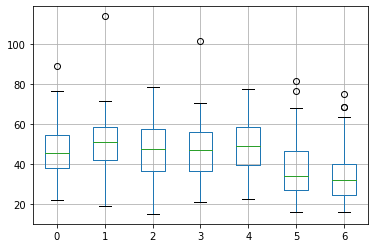

In [234]:
# Answer
data['2012'].groupby(['weekday', 'week'])['FR04037'].mean().unstack(level=0).boxplot();

<div class="alert alert-success">
    <b>QUESTION</b>: The maximum daily 8 hour mean should be below 100 µg/m³. What are the number of exceedances of this limit for each year?
</div>

Tip: have a look at the `rolling` method to perform moving window operations.

Note: this is not an actual limit for NO2, but a nice exercise to introduce the `rolling` method. Other pollutans, such as 03 have actually such kind of limit values.

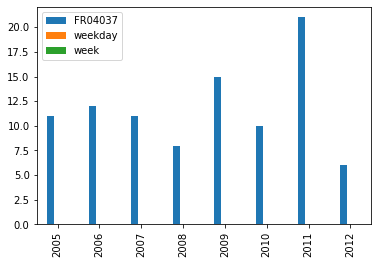

In [235]:
# Answer
exceedances = data.rolling(8).mean().resample('D').max() > 100
exceedances = exceedances.groupby(exceedances.index.year).sum()
ax = exceedances.loc[2005:].plot(kind='bar')

### Do the same analysis with `BETN0290000800100hour.1-1-1990.31-12-2012` data

In [236]:
with open("BETN0290000800100hour.1-1-1990.31-12-2012") as k:
    print(k.readline())

1990-01-01	16.000	1	18.000	1	21.000	1	26.000	1	21.000	1	19.000	1	19.000	1	16.000	1	15.000	1	13.000	1	12.000	1	16.000	1	-999.000	0	-999.000	0	19.000	1	26.000	1	23.000	1	23.000	1	28.000	1	41.000	1	32.000	1	21.000	1	23.000	1	25.000	1



In [237]:
data1 = pd.read_csv("BETN0290000800100hour.1-1-1990.31-12-2012", sep='\t')#, header=None)
data1.head()

,1990-01-01,16.000,1,18.000,1.1,21.000,1.2,26.000,1.3,21.000.1,1.4,19.000,1.5,19.000.1,1.6,16.000.1,1.7,15.000,1.8,13.000,1.9,12.000,1.10,16.000.2,1.11,-999.000,0,-999.000.1,0.1,19.000.2,1.12,26.000.1,1.13,23.000,1.14,23.000.1,1.15,28.000,1.16,41.000,1.17,32.000,1.18,21.000.2,1.19,23.000.2,1.20,25.000,1.21
0,1990-01-02,19.0,1,22.0,1,22.0,1,25.0,1,28.0,1,31.0,1,39.0,1,42.0,1,40.0,1,36.0,1,30.0,1,-999.0,0,-999.0,0,25.0,1,30.0,1,23.0,1,25.0,1,34.0,1,54.0,1,59.0,1,58.0,1,52.0,1,40.0,1,36.0,1
1,1990-01-03,39.0,1,33.0,1,23.0,1,12.0,1,15.0,1,10.0,1,12.0,1,18.0,1,22.0,1,29.0,1,-999.0,0,-999.0,0,29.0,1,30.0,1,28.0,1,36.0,1,25.0,1,28.0,1,42.0,1,47.0,1,47.0,1,41.0,1,38.0,1,37.0,1
2,1990-01-04,49.0,1,52.0,1,55.0,1,57.0,1,58.0,1,51.0,1,39.0,1,31.0,1,24.0,1,-999.0,0,-999.0,0,28.0,1,35.0,1,40.0,1,45.0,1,48.0,1,49.0,1,49.0,1,44.0,1,45.0,1,43.0,1,42.0,1,32.0,1,23.0,1
3,1990-01-05,20.0,1,23.0,1,38.0,1,55.0,1,61.0,1,64.0,1,67.0,1,66.0,1,-999.0,0,-999.0,0,57.0,1,51.0,1,47.0,1,33.0,1,27.0,1,24.0,1,25.0,1,37.0,1,36.0,1,46.0,1,34.0,1,22.0,1,21.0,1,29.0,1
4,1990-01-06,39.0,1,56.0,1,61.0,1,60.0,1,46.0,1,16.0,1,11.0,1,-999.0,0,-999.0,0,28.0,1,27.0,1,22.0,1,19.0,1,21.0,1,24.0,1,16.0,1,17.0,1,18.0,1,16.0,1,17.0,1,18.0,1,18.0,1,16.0,1,18.0,1


In [238]:
data1 = pd.read_csv("BETN0290000800100hour.1-1-1990.31-12-2012",
                  sep = '\t', header = None, na_values = [-999,-9999])
data1.columns = column_names
data1.head()

,date,00,flag,01,flag,02,flag,03,flag,04,flag,05,flag,06,flag,07,flag,08,flag,09,flag,10,flag,11,flag,12,flag,13,flag,14,flag,15,flag,16,flag,17,flag,18,flag,19,flag,20,flag,21,flag,22,flag,23,flag
0,1990-01-01,16.0,1,18.0,1,21.0,1,26.0,1,21.0,1,19.0,1,19.0,1,16.0,1,15.0,1,13.0,1,12.0,1,16.0,1,NaN,0,NaN,0,19.0,1,26.0,1,23.0,1,23.0,1,28.0,1,41.0,1,32.0,1,21.0,1,23.0,1,25.0,1
1,1990-01-02,19.0,1,22.0,1,22.0,1,25.0,1,28.0,1,31.0,1,39.0,1,42.0,1,40.0,1,36.0,1,30.0,1,NaN,0,NaN,0,25.0,1,30.0,1,23.0,1,25.0,1,34.0,1,54.0,1,59.0,1,58.0,1,52.0,1,40.0,1,36.0,1
2,1990-01-03,39.0,1,33.0,1,23.0,1,12.0,1,15.0,1,10.0,1,12.0,1,18.0,1,22.0,1,29.0,1,NaN,0,NaN,0,29.0,1,30.0,1,28.0,1,36.0,1,25.0,1,28.0,1,42.0,1,47.0,1,47.0,1,41.0,1,38.0,1,37.0,1
3,1990-01-04,49.0,1,52.0,1,55.0,1,57.0,1,58.0,1,51.0,1,39.0,1,31.0,1,24.0,1,NaN,0,NaN,0,28.0,1,35.0,1,40.0,1,45.0,1,48.0,1,49.0,1,49.0,1,44.0,1,45.0,1,43.0,1,42.0,1,32.0,1,23.0,1
4,1990-01-05,20.0,1,23.0,1,38.0,1,55.0,1,61.0,1,64.0,1,67.0,1,66.0,1,NaN,0,NaN,0,57.0,1,51.0,1,47.0,1,33.0,1,27.0,1,24.0,1,25.0,1,37.0,1,36.0,1,46.0,1,34.0,1,22.0,1,21.0,1,29.0,1


In [239]:
flag_columns1 = [col for col in data1.columns if 'flag' in col]
data1 = data1.drop(flag_columns1, axis = 1)
data1.head()

,date,00,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,1990-01-01,16.0,18.0,21.0,26.0,21.0,19.0,19.0,16.0,15.0,13.0,12.0,16.0,NaN,NaN,19.0,26.0,23.0,23.0,28.0,41.0,32.0,21.0,23.0,25.0
1,1990-01-02,19.0,22.0,22.0,25.0,28.0,31.0,39.0,42.0,40.0,36.0,30.0,NaN,NaN,25.0,30.0,23.0,25.0,34.0,54.0,59.0,58.0,52.0,40.0,36.0
2,1990-01-03,39.0,33.0,23.0,12.0,15.0,10.0,12.0,18.0,22.0,29.0,NaN,NaN,29.0,30.0,28.0,36.0,25.0,28.0,42.0,47.0,47.0,41.0,38.0,37.0
3,1990-01-04,49.0,52.0,55.0,57.0,58.0,51.0,39.0,31.0,24.0,NaN,NaN,28.0,35.0,40.0,45.0,48.0,49.0,49.0,44.0,45.0,43.0,42.0,32.0,23.0
4,1990-01-05,20.0,23.0,38.0,55.0,61.0,64.0,67.0,66.0,NaN,NaN,57.0,51.0,47.0,33.0,27.0,24.0,25.0,37.0,36.0,46.0,34.0,22.0,21.0,29.0


In [240]:
dataa = data1.set_index('date')
data_stacked1 = dataa.stack()
data_stacked1.head()

date          
1990-01-01  00    16.0
            01    18.0
            02    21.0
            03    26.0
            04    21.0
dtype: float64

In [241]:
data_stacked1 = data_stacked1.reset_index()
data_stacked1.head()

,date,level_1,0
0,1990-01-01,00,16.0
1,1990-01-01,01,18.0
2,1990-01-01,02,21.0
3,1990-01-01,03,26.0
4,1990-01-01,04,21.0


In [242]:
data_stacked1.index = pd.to_datetime(data_stacked1['date'] + data_stacked1['level_1'], format="%Y-%m-%d%H")
data_stacked1 = data_stacked1.drop(['date', 'level_1'], axis=1)
data_stacked1.head()

,0
1990-01-01 00:00:00,16.0
1990-01-01 01:00:00,18.0
1990-01-01 02:00:00,21.0
1990-01-01 03:00:00,26.0
1990-01-01 04:00:00,21.0


In [243]:
data_stacked1 = data_stacked1.rename(columns={0: 'BETN029'})
data_stacked1.head()

,BETN029
1990-01-01 00:00:00,16.0
1990-01-01 01:00:00,18.0
1990-01-01 02:00:00,21.0
1990-01-01 03:00:00,26.0
1990-01-01 04:00:00,21.0


In [244]:
data_stacked1.index

DatetimeIndex(['1990-01-01 00:00:00', '1990-01-01 01:00:00',
               '1990-01-01 02:00:00', '1990-01-01 03:00:00',
               '1990-01-01 04:00:00', '1990-01-01 05:00:00',
               '1990-01-01 06:00:00', '1990-01-01 07:00:00',
               '1990-01-01 08:00:00', '1990-01-01 09:00:00',
               ...
               '2012-12-31 14:00:00', '2012-12-31 15:00:00',
               '2012-12-31 16:00:00', '2012-12-31 17:00:00',
               '2012-12-31 18:00:00', '2012-12-31 19:00:00',
               '2012-12-31 20:00:00', '2012-12-31 21:00:00',
               '2012-12-31 22:00:00', '2012-12-31 23:00:00'],
              dtype='datetime64[ns]', length=174807, freq=None)

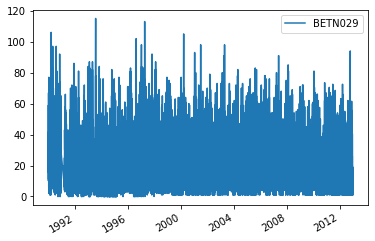

In [245]:
data_stacked1.plot()

In [246]:
def read_airbase_file(filename1, station1):
    """
    Read hourly AirBase data files.
    
    Parameters
    ----------
    filename1 : string
        Path to the data file.
    station1 : string
        Name of the station.
       
    Returns
    -------
    DataFrame
        Processed dataframe.
    """
    # Column names: list consisting of 'date' and then intertwined the hour of the day and 'flag'
    hours = ["{:02d}".format(i) for i in range(24)]
    colnames = ['date'] + [item for pair in zip(hours, ['flag']*24) for item in pair]
    
    # read the actual data
    data1 = pd.read_csv("BETN0290000800100hour.1-1-1990.31-12-2012", sep = '\t', header = None, na_values = [-999,-9999])
    data1.columns = colnames
    
    #drop the 'flag' columns
    data1 = data1.drop([col for col in data1.columns if 'flag' in col], axis = 1)
    
    #reshape
    dataa = data1.set_index('date')
    data_stacked1 = dataa.stack()
    data_stacked1 = data_stacked1.reset_index()
    
    #parse to datetime and remove redundant columns
    data_stacked1.index = pd.to_datetime(data_stacked1['date'] + data_stacked1['level_1'], format="%Y-%m-%d%H")
    data_stacked1 = data_stacked1.drop(['date', 'level_1'], axis=1)
    data_stacked1 = data_stacked1.rename(columns={0: station1})

    return data_stacked1

In [247]:
filename1 = "BETN0290000800100hour.1-1-1990.31-12-2012"
station1 = filename1.split("/")[-1][:7]
station1

'BETN029'

In [248]:
test1 = read_airbase_file(filename1, station1)
test1.head()

,BETN029
1990-01-01 00:00:00,16.0
1990-01-01 01:00:00,18.0
1990-01-01 02:00:00,21.0
1990-01-01 03:00:00,26.0
1990-01-01 04:00:00,21.0


In [254]:
alldata1 = pd.read_csv('airbase_data1.csv', index_col=0, parse_dates=True)
data1 = alldata1['1999':].copy()
data1.head()

,BETN029
1999-01-01 00:00:00,27.0
1999-01-01 01:00:00,33.0
1999-01-01 02:00:00,24.0
1999-01-01 03:00:00,26.0
1999-01-01 06:00:00,34.0


In [255]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106628 entries, 1999-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   BETN029  106628 non-null  float64
dtypes: float64(1)
memory usage: 1.6 MB


In [257]:
data1.describe(percentiles=[0.1, 0.5, 0.9])

,BETN029
count,106628.000000
mean,46.728969
std,21.708333
min,1.000000
10%,21.000000
50%,45.000000
90%,75.000000
max,339.000000


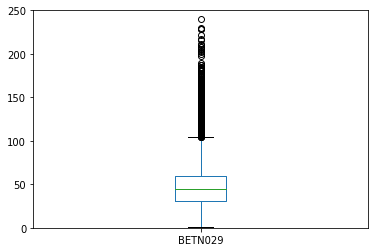

In [258]:
data1.plot(kind='box', ylim=[0,250])

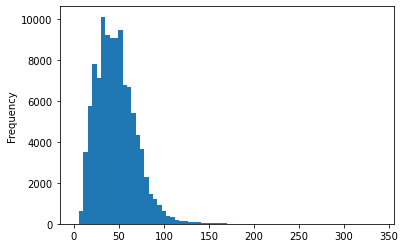

In [259]:
data1['BETN029'].plot(kind='hist', bins=70)

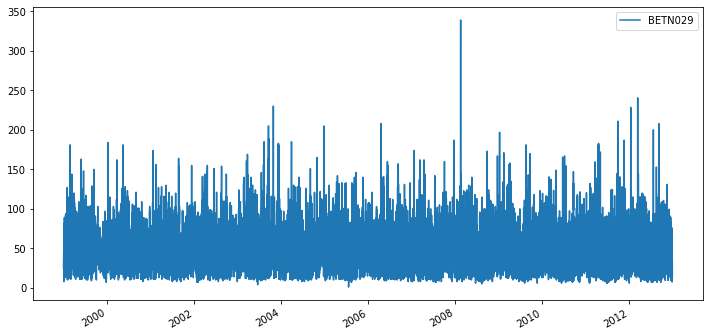

In [260]:
data1.plot(figsize=(12,6))

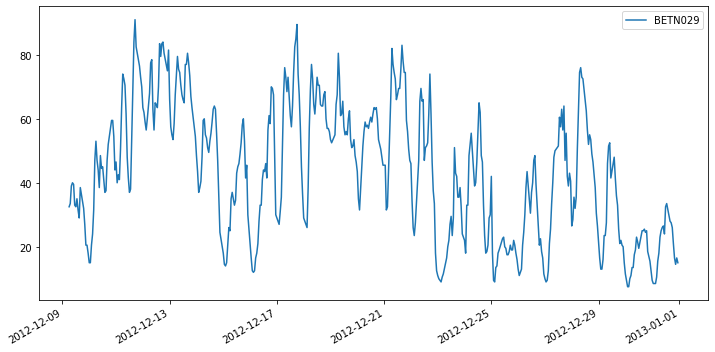

In [261]:
data1[-500:].plot(figsize=(12,6))

In [262]:
data_files = glob.glob("*0290000*")
data_files

['BETN0290000800100hour.1-1-1990.31-12-2012']

In [267]:
dfs1 = []

for filename1 in data_files:
    station1 = filename1.split("/")[-1][:7]
    df1 = read_airbase_file(filename1, station1)
    dfs1.append(df1)

In [269]:
combined_data1 = pd.concat(dfs1, axis=1)
combined_data1.head()

,BETN029
1990-01-01 00:00:00,16.0
1990-01-01 01:00:00,18.0
1990-01-01 02:00:00,21.0
1990-01-01 03:00:00,26.0
1990-01-01 04:00:00,21.0


In [270]:
data1 = combined_data1.copy()
data1.head()

,BETN029
1990-01-01 00:00:00,16.0
1990-01-01 01:00:00,18.0
1990-01-01 02:00:00,21.0
1990-01-01 03:00:00,26.0
1990-01-01 04:00:00,21.0


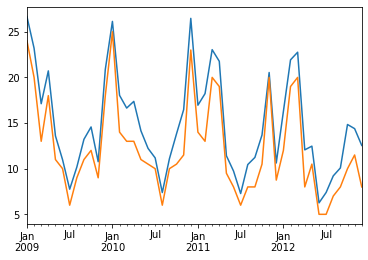

In [271]:
data1.loc['2009':, 'BETN029'].resample('M').mean().plot()
data1.loc['2009':, 'BETN029'].resample('M').median().plot()

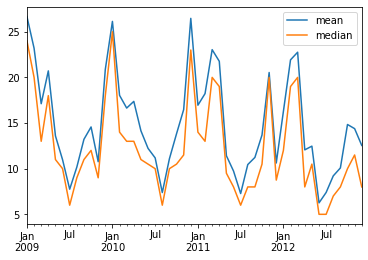

In [272]:
data1.loc['2009':, 'BETN029'].resample('M').agg(['mean', 'median']).plot()

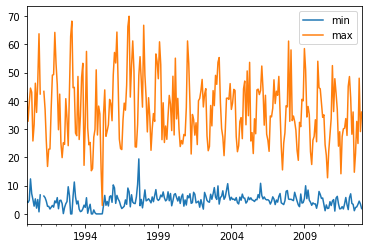

In [273]:
daily1 = data1['BETN029'].resample('D').mean()
daily1.resample('M').agg(['min', 'max']).plot()

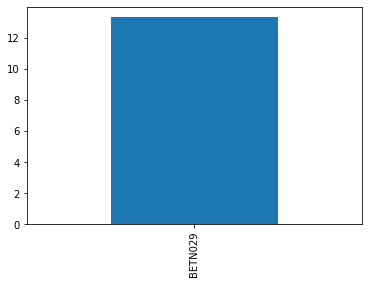

In [274]:
data1['2012'].mean().plot(kind='bar')

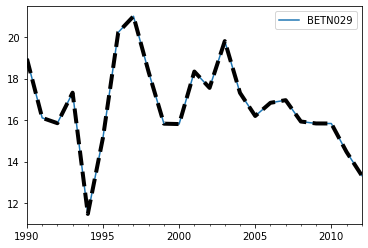

In [275]:
data1.resample('A').mean().plot()
data1.mean(axis = 1).resample('A').mean().plot(color = 'k', linestyle = '--', linewidth = 4)

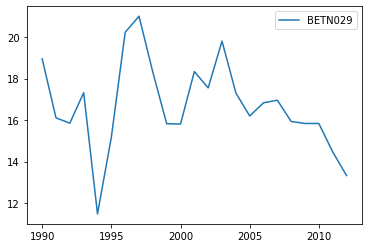

In [277]:
data1.groupby(data1.index.year).mean().plot()

In [278]:
data1['month']= data1.index.month
data1.groupby('month').mean()

,BETN029
month,
1,20.304075
2,19.938929
3,19.424205
4,18.183433
...,...
9,14.605979
10,17.660149
11,19.372193
12,21.007089


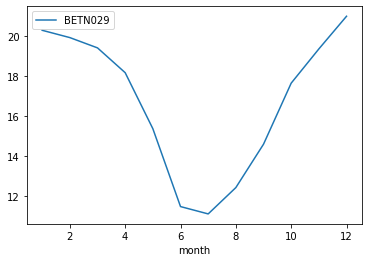

In [279]:
data1.groupby('month').mean().plot()

In [280]:
data1 = data1.drop('month', axis=1, errors='ignore')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


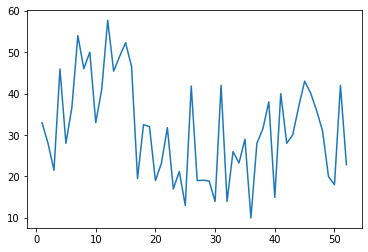

In [282]:
df2011a = data1['2011'].dropna()
df2011a = data1['2011'].dropna()
df2011a.groupby(df2011a.index.week)['BETN029'].quantile(0.95).plot()

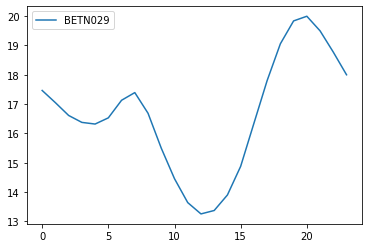

In [283]:
data1.groupby(data1.index.hour).mean().plot()

In [284]:
exceedances1 = data1 > 200
exceedances1 = exceedances1.groupby(exceedances1.index.year).sum()
exceedances1

,BETN029
1990,0
1991,0
1992,0
1993,0
...,...
2009,0
2010,0
2011,0
2012,0


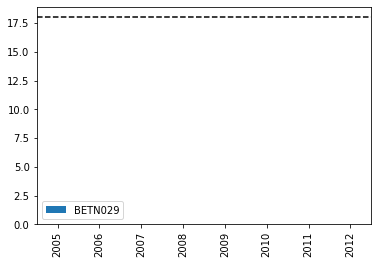

In [286]:
ax1 = exceedances1.loc[2005:].plot(kind='bar')
ax1.axhline(18, color='k', linestyle='--')

In [287]:
yearly1 = data1['2000':].resample('A').mean()
(yearly1 > 40).sum()

BETN029    0
dtype: int64

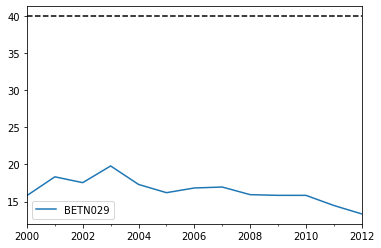

In [288]:
yearly1.plot()
plt.axhline(40, linestyle='--', color='k')

In [289]:
data1['weekday'] = data1.index.weekday
data1['weekend'] = data1['weekday'].isin([5,6])
data_weekend1 = data1.groupby(['weekend', data1.index.hour]).mean()
data_weekend1.head()

BETN029   weekday
weekend                       
False   0  17.487512  2.012393
        1  17.162671  2.009132
        2  16.800076  2.008585
        3  16.591031  2.005941
        4  16.791971  2.009220

In [290]:
data_weekend_BETN029 = data_weekend1['BETN029'].unstack(level=0)
data_weekend_BETN029.head()

weekend,False,True
0,17.487512,17.409112
1,17.162671,16.762607
2,16.800076,16.146081
3,16.591031,15.843705
4,16.791971,15.150333


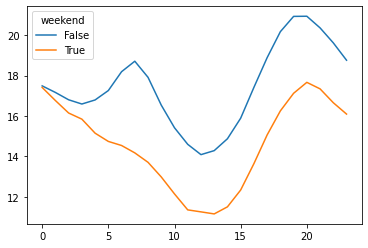

In [291]:
data_weekend_BETN029.plot()

In [292]:
data1 = data1.drop(['weekday', 'weekend'], axis=1)
data1['weekday'] = data1.index.weekday
data1['week'] = data1.index.week
data1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  This is separate from the ipykernel package so we can avoid doing imports until


,BETN029,weekday,week
1990-01-01 00:00:00,16.0,0,1
1990-01-01 01:00:00,18.0,0,1
1990-01-01 02:00:00,21.0,0,1
1990-01-01 03:00:00,26.0,0,1
1990-01-01 04:00:00,21.0,0,1


In [294]:
data_pivoted1 = data1['2012'].pivot_table(columns = 'weekday', index='week', values='BETN029')
data_pivoted1.head()

weekday,0,1,2,3,4,5,6
week,,,,,,,
1,3.456522,3.478261,6.391304,3.978261,11.282609,8.826087,11.239130
2,23.869565,21.717391,12.760870,10.173913,9.521739,16.478261,27.958333
3,43.086957,45.125000,24.913043,13.130435,14.847826,7.760870,7.739130
4,17.391304,17.456522,18.413043,9.456522,11.869565,19.913043,24.108696
5,21.478261,36.891304,26.586957,25.159091,25.195652,48.586957,15.195652


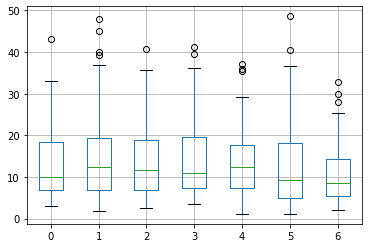

In [295]:
box1 = data_pivoted1.boxplot()

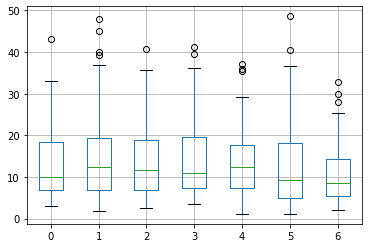

In [296]:
data1['2012'].groupby(['weekday', 'week'])['BETN029'].mean().unstack(level=0).boxplot();

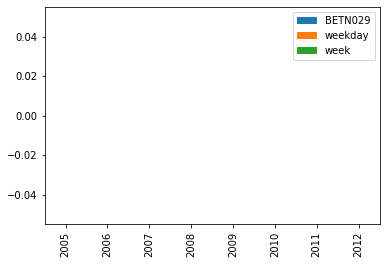

In [298]:
exceedances1 = data1.rolling(8).mean().resample('D').max() > 100
exceedances1 = exceedances1.groupby(exceedances1.index.year).sum()
ax1 = exceedances1.loc[2005:].plot(kind='bar')